In [1]:
# Keyword Frequency Sector Momentum 전략 백테스트
# Monthly rebalancing 가정
# 모멘텀 측정기간(tau), 투자 시작일(stDateNum)을 바꿔가며 Back-test 가능

# 현재 디렉토리 확인
import os
os.getcwd()

# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
# ============================================================================
# Data 로딩 및 변수 정의
# ============================================================================
# 날짜 기준으로 오름차순 정렬된 Data 불러오기
data_excel = pd.ExcelFile('./Data/Sector_Data_m.xlsx') # read_excel과 차이= 엑셀 시트 여러개를 한번에 가져옴
price_df = data_excel.parse(sheet_name = 'P_m', header=4) # Price Data d / w(Fri) / m(EoM)
rawTime = price_df.iloc[:, 0].copy()     # Date
rawMarket = price_df.iloc[:, 1].copy()   # Market Price (MKF500)
rawSector = price_df.iloc[:, 2:-1].copy()
rawCD = price_df.iloc[:, -1].copy()       # Risk-free rate (CD1m, %)
rawWord = data_excel.parse(sheet_name = 'W_m', header=1, index_col=0)
numRaw = len(rawTime)   
numSector = len(rawSector.columns)

# Sector HPR (based on TR Index, %)
rawRm = rawMarket.pct_change()*100 # (rawMarket / rawMarket.shift(1) - 1) * 100
rawRs = rawSector.pct_change()*100 # (rawSector / rawSector.shift(1) - 1) * 100
rawRf = rawCD.shift(1)/12 # CD1m의 정의를 고려하여 1칸 shift + 연율화 scaling

# Sector List
Sector_list = ['ENE', 'MAT', 'IND', 'UTI', 'COM', 'INT', 'COD', 'COS', 'HEL','FIN']

# 전체 데이터에서 섹터별 데이터로 분할
Sector_dict={}
for i,j in zip(Sector_list,range(0,len(rawWord.columns),5)) :
    Sector_dict[i] = rawWord.iloc[:,j:j+5].copy()
    
# Keyword Sector Momentum (based on Frequency Index, %)
Sum_dict = {}
Rt_dict = {}
tau = 1

for i in Sector_list : 
    Sum_dict[i] = Sector_dict[i].sum(axis=1).copy()
    Rt_dict[i] = Sum_dict[i].pct_change(tau)

# 키워드 Return을 섹터별로 데이터프레임에 저장
rawKeyword = pd.DataFrame()
for i in Rt_dict : 
    rawKeyword[i] = Rt_dict[i]

# Tau기간에 대한 Secetor의 mometum
Mom = rawSector.pct_change(tau)

In [3]:
# ============================================================================
# Back Test 시작시점 기준으로 데이터 정리 (이 작업을 원하지 않으면 엑셀을 편집)
# ============================================================================
stDateNum = 20040101  # 20021231  # Back Test 시작일 (투자 시작일)
stDate = pd.to_datetime(str(stDateNum), format='%Y%m%d')
idx = np.argmin(np.abs(rawTime - stDate))  # Back Test 시작일에 해당하는 index

Time = rawTime[idx:].copy().reset_index(drop = True)  # 깊은 복사, index 초기화
Rm = rawRm[idx:].copy().reset_index(drop = True)
Rs = rawRs[idx:].copy().reset_index(drop = True)
Rf = rawRf[idx:].copy().reset_index(drop = True)
Keyword = rawKeyword[idx:].copy().reset_index(drop = True)
numData = Time.shape[0]  # len(Data) or len(Data.index)


WordSignal = 1*(Keyword > 0) # 1: 빈도상승 / 0: 빈도하락
MomSignal = 1*(Mom > 0) # 1: 모멘텀 있음 / 0: 모멘텀 없음

# Signal = WordSignal*MomSignal # 1st order, 2nd order 동시 충족

Signal = 1*(Keyword > 0) # 1: 빈도상승 / 0: 빈도하락

W1 = Signal  # Risky asset 투자비중
W2 = 1 - W1  # Risk - free asset 투자비중

# Portfolio Value
Rp = pd.DataFrame(np.zeros([numData, numSector]),columns=(Sector_list)) # 수익률 (단위: %)
Vp = pd.DataFrame(np.zeros([numData, numSector]),columns=(Sector_list)) # Value
Vp.iloc[0,:] = 100 # 투자원금 = 100

for i in Sector_list : 
    for t in range(1, numData) : 
        Rp[i][t] = W1[i][t-1]*Rs[i][t] + W2[i][t-1]*Rf[t]   # HPR
        Vp[i][t] = Vp[i][t-1]*(1 + Rp[i][t]/100)         # Value
    
# Portfolio DD
MAXp = Vp.cummax()
DDp = (Vp/MAXp - 1) * 100  # 단위: %

In [4]:
# =================================================
# BM Value (투자 시작일 기준으로 표준화)
# =================================================

# Benchmark (Equally-Weighted Sector)
Rb = pd.Series(np.zeros(numData)) # 수익률 (단위: %)
Vb1 = pd.Series(np.zeros(numData)) # Value
Vb1[0] = 100
Wb = pd.DataFrame(np.ones([numData, numSector]),columns=(Sector_list))/numSector

for t in range(1, numData) : 
    Rb.iloc[t] = Wb.iloc[t-1,:]@Rs.iloc[t,:]   # HPR 내적
    Vb1.iloc[t] = Vb1.iloc[t-1]*(1 + Rb.iloc[t]/100)   # Value
            
# BM DD
MAXb1 = Vb1.cummax()
DDb1 = (Vb1 / MAXb1 - 1) * 100  # 단위: %

# Benchmark (MKF500)
Vb2 = pd.Series(np.zeros(numData)) # Value
Vb2[0] = 100 # 투자원금 = 100

for t in range(1, numData) :
    Vb2[t] = Vb2[t-1]*(1 + Rm[t]/100) # Market Return
    
# BM DD
MAXb2 = Vb2.cummax()
DDb2 = (Vb2 / MAXb2 - 1) * 100  # 단위: %

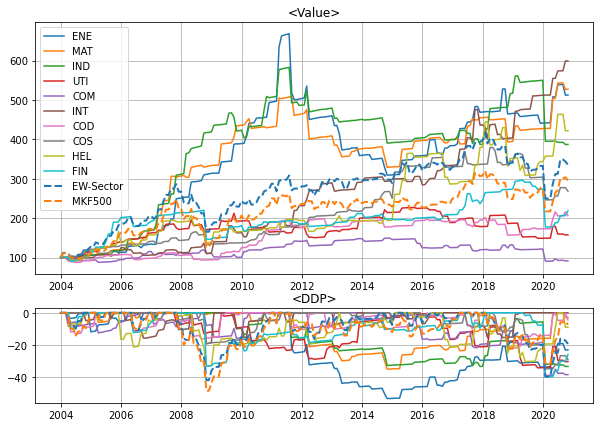

In [5]:
# Value와 MDD 그리기
fig = plt.figure(figsize = (10, 7))    # figsize = (가로길이, 세로길이)
gs = gridspec.GridSpec(nrows = 2,      # row 개수
                       ncols = 1,      # col 개수
                       height_ratios=[8, 3],
                       width_ratios=[5])    # subplot의 크기를 서로 다르게 설정

ax0 = plt.subplot(gs[0])
ax0.plot(Time, Vp.iloc[:,0], label = 'ENE')
ax0.plot(Time, Vp.iloc[:,1], label = 'MAT')
ax0.plot(Time, Vp.iloc[:,2], label = 'IND')
ax0.plot(Time, Vp.iloc[:,3], label = 'UTI')
ax0.plot(Time, Vp.iloc[:,4], label = 'COM')
ax0.plot(Time, Vp.iloc[:,5], label = 'INT')
ax0.plot(Time, Vp.iloc[:,6], label = 'COD')
ax0.plot(Time, Vp.iloc[:,7], label = 'COS')
ax0.plot(Time, Vp.iloc[:,8], label = 'HEL')
ax0.plot(Time, Vp.iloc[:,9], label = 'FIN')
ax0.plot(Time, Vb1, label = 'EW-Sector', linewidth=2, linestyle='--')
ax0.plot(Time, Vb2, label = 'MKF500', linewidth=2, linestyle='--')
ax0.set_title('<Value>')
ax0.grid(True)
ax0.legend()

ax1 = plt.subplot(gs[1])
ax1.plot(Time, DDp.iloc[:,0], label = 'ENE')
ax1.plot(Time, DDp.iloc[:,1], label = 'MAT')
ax1.plot(Time, DDp.iloc[:,2], label = 'IND')
ax1.plot(Time, DDp.iloc[:,3], label = 'UTI')
ax1.plot(Time, DDp.iloc[:,4], label = 'COM')
ax1.plot(Time, DDp.iloc[:,5], label = 'INT')
ax1.plot(Time, DDp.iloc[:,6], label = 'COD')
ax1.plot(Time, DDp.iloc[:,7], label = 'COS')
ax1.plot(Time, DDp.iloc[:,8], label = 'HEL')
ax1.plot(Time, DDp.iloc[:,9], label = 'FIN')
ax1.plot(Time, DDb1, label = 'EW-Sector', linewidth=2, linestyle='--')
ax1.plot(Time, DDb2, label = 'MKF500', linewidth=2, linestyle='--')
ax1.set_title('<DDP>')
ax1.grid(True)

plt.show()